In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'int-sys-main:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4425003%2F7601220%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240211%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240211T061056Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da887f9170e4d6d3e99d19b18608a13acca66e3da5b0c4964959bd80183a0a9f4dca6adf0e64662039a5ee2bf48456ff7f47b7106ab8efb1b6af361cd9775277e82329a88712f4c0f1e884c92155d07675f889142668cc4ff4235bc9c176a5cf86c78787293a5dcc3560ddaf2fcb1c2be2ea993f4c455bbf8eaba5bb7782662d9b706ad72df36effc6225c4ac95396ba9ec87aef9f960b47b6188e13c9b06306bf7f1f89c157f986a3cc994ca46ef77dbfd038fc96be3e934c5af1d77ac990584d17927190636000cd5bc43ea96473b43990562919bde53bee2bf305112d7b0c4ef3d294d7be900210842b8da63fd59c654761fe65036d17b0e9f6d621a7acf7f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 70983306 bytes downloaded
Downloaded and uncompressed: int-sys-main
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import re

In [3]:
sntncs=[]
with open('/kaggle/input/int-sys-main/imdb_labelled.txt', 'r') as file:
    content = file.read()
    label = [int(s) for s in re.findall(r'\t\d+\b', content)]
    label.append(0)
    content = re.sub(r'[^a-zA-Z\s]', '', content)

#     content = content.replace('0','1')
    sall = content.split('\t\n')

    for i in sall:
        sntncs.append(i.strip())


In [4]:
for i in range(len(sntncs)):
    sntncs[i] = sntncs[i].lower()

*italicised text*

In [5]:
df_word = pd.DataFrame(columns=['sentence'])
for i in range(len(sntncs)):
    df_word.loc[len(df_word)] = sntncs[i]

# df_word['label'] = label
df_word.head()

,sentence
0,a very very very slowmoving aimless movie abou...
1,not sure who was more lost the flat character...
2,attempting artiness with black white and clev...
3,very little music or anything to speak of
4,the best scene in the movie was when gerardo i...


In [6]:
word_to_vec_map = {}
with open('/kaggle/input/int-sys-main/glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_to_vec_map[word] = coefs

# Map words in the dataset to their corresponding word vectors
def words_to_vectors(words):
    return [word_to_vec_map[word] for word in words if word in word_to_vec_map]

imdb_data = pd.DataFrame(columns=['sentence'])
imdb_data['sentence'] = df_word['sentence'].apply(words_to_vectors)


In [7]:
imdb_data['label'] = label
imdb_data

,sentence,label
0,"[[0.21705, 0.46515, -0.46757, 0.10082, 1.0135,...",0
1,"[[-0.27004, 1.1144, 1.0493, 0.57924, 0.78968, ...",0
2,"[[0.21705, 0.46515, -0.46757, 0.10082, 1.0135,...",0
3,"[[0.18445, 1.2654, 0.039013, 0.81299, -0.38684...",0
4,"[[-0.37915, 0.61848, 0.9593, 0.90403, 0.36806,...",1
...,...,...
996,"[[-0.25676, 0.8549, 1.1003, 0.95363, 0.36585, ...",0
997,"[[0.11891, 0.15255, -0.082073, -0.74144, 0.759...",0
998,"[[0.73833, 0.65451, 1.0873, 0.86066, -0.4834, ...",0
999,"[[0.21705, 0.46515, -0.46757, 0.10082, 1.0135,...",0


In [8]:
nan=[]
for i in range(len(imdb_data['sentence'])):
    if imdb_data['sentence'][i]==[]:
        nan.append(i)

nan

[125, 788, 1000]

In [9]:
imdb_data.drop(nan, inplace=True)
imdb_data.reset_index(inplace=True)
imdb_data.drop('index',axis=1, inplace=True)
imdb_data

,sentence,label
0,"[[0.21705, 0.46515, -0.46757, 0.10082, 1.0135,...",0
1,"[[-0.27004, 1.1144, 1.0493, 0.57924, 0.78968, ...",0
2,"[[0.21705, 0.46515, -0.46757, 0.10082, 1.0135,...",0
3,"[[0.18445, 1.2654, 0.039013, 0.81299, -0.38684...",0
4,"[[-0.37915, 0.61848, 0.9593, 0.90403, 0.36806,...",1
...,...,...
993,"[[0.11891, 0.15255, -0.082073, -0.74144, 0.759...",0
994,"[[-0.25676, 0.8549, 1.1003, 0.95363, 0.36585, ...",0
995,"[[0.11891, 0.15255, -0.082073, -0.74144, 0.759...",0
996,"[[0.73833, 0.65451, 1.0873, 0.86066, -0.4834, ...",0


In [ ]:
# max_len = max(imdb_data['sentence'].apply(len))
# for i in range(len(imdb_data['sentence'])):
#     ll = len(imdb_data['sentence'][i])
#     for j in range(max_len-ll):
#         imdb_data['sentence'][i].append(np.zeros((50,)))


In [10]:
from keras.preprocessing.sequence import pad_sequences

max_len = max(imdb_data.apply(len))
padded_sequences = pad_sequences(imdb_data['sentence'], maxlen=max_len, dtype='float32')
padded_sequences

array([[[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [-0.47714 ,  1.7847  ,  1.3788  , ..., -0.94238 , -0.29406 ,
         -0.18219 ],
        [ 0.21705 ,  0.46515 , -0.46757 , ..., -0.043782,  0.41013 ,
          0.1796  ],
        [-0.27004 ,  1.1144  ,  1.0493  , ..., -0.77324 ,  0.42681 ,
          1.0782  ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [-0.043861,  1.3183  , -0.03715 , ..., -0.86275 ,  1.2377  ,
          0.87426 ],
        [-0.25676 ,  0.8549  ,  1.1003  , ..., -0.22177 ,  0.099708,
   

In [11]:
from sklearn.model_selection import train_test_split

sentences_train, sentences_test, y_train, y_test = train_test_split(padded_sequences, imdb_data['label'], test_size=0.25, random_state=1000)


In [12]:
from keras import models, layers

model = models.Sequential([
    layers.Dense(max_len, input_shape=(max_len, 50)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 998, 998)          50898     
                                                                 
 dense_1 (Dense)             (None, 998, 64)           63936     
                                                                 
 dense_2 (Dense)             (None, 998, 1)            65        
                                                                 
Total params: 114899 (448.82 KB)
Trainable params: 114899 (448.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# Train the model with padded_sequences as input and labels as output
history = model.fit(sentences_train, y_train, epochs=200, verbose=False, batch_size=32, validation_data=(sentences_test, y_test))

loss, accuracy = model.evaluate(sentences_test, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))

8/8 [==============================] - 0s 10ms/step - loss: 0.6953 - accuracy: 0.4560
Testing Accuracy:  0.4560


In [14]:
from keras.optimizers import Adam, SGD

# Define a list of learning rates to experiment with
learning_rates = [0.001, 0.0001, 0.00001]
i=1

for lr in learning_rates:
    model1 = models.Sequential([
    layers.Dense(max_len, input_shape=(max_len, 50)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])
        # Choose an optimizer with the current learning rate
    optimizer1 = Adam(lr=lr)

    # Train the model with the current learning rate
    model1.compile(optimizer=optimizer1, loss='binary_crossentropy', metrics=['accuracy'])
    print(model1.summary(),"\n...........")

    history1 = model1.fit(sentences_train, y_train, epochs=200, batch_size=32)

    loss, accuracy = model1.evaluate(sentences_test, y_test)
    print(f"{i}: "+"Testing Accuracy of :  {:.4f}".format(accuracy))
    i+=1

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 998, 998)          50898     
                                                                 
 dense_4 (Dense)             (None, 998, 64)           63936     
                                                                 
 dense_5 (Dense)             (None, 998, 1)            65        
                                                                 
Total params: 114899 (448.82 KB)
Trainable params: 114899 (448.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None 
...........
Epoch 1/200
24/24 [==============================] - 2s 16ms/step - loss: 0.6942 - accuracy: 0.5035
Epoch 2/200
24/24 [==============================] - 0s 13ms/step - loss: 0.6933 - accuracy: 0.5131
Epoch 3/200
24/24 [==============================] - 0s 13ms

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 998, 998)          50898     
                                                                 
 dense_7 (Dense)             (None, 998, 64)           63936     
                                                                 
 dense_8 (Dense)             (None, 998, 1)            65        
                                                                 
Total params: 114899 (448.82 KB)
Trainable params: 114899 (448.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None 
...........
Epoch 1/200
24/24 [==============================] - 1s 16ms/step - loss: 0.6953 - accuracy: 0.5067
Epoch 2/200
24/24 [==============================] - 0s 13ms/step - loss: 0.6932 - accuracy: 0.4916
Epoch 3/200
24/24 [==============================] - 0s 13ms

2: Testing Accuracy of :  0.4560
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 998, 998)          50898     
                                                                 
 dense_10 (Dense)            (None, 998, 64)           63936     
                                                                 
 dense_11 (Dense)            (None, 998, 1)            65        
                                                                 
Total params: 114899 (448.82 KB)
Trainable params: 114899 (448.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None 
...........
Epoch 1/200
24/24 [==============================] - 2s 21ms/step - loss: 0.6945 - accuracy: 0.4832
Epoch 2/200
24/24 [==============================] - 0s 18ms/step - loss: 0.6929 - accuracy: 0.5134
Epoch 3/200
24/24 [========

In [15]:
# Choose two different optimizers
optimizer1 = Adam(lr=0.0001)

model2 = models.Sequential([
    layers.Dense(max_len, input_shape=(max_len, 50)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])
# Train the model with the first optimizer
model2.compile(optimizer=optimizer1, loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

history2 = model2.fit(sentences_train, y_train, epochs=100, batch_size=32)

loss, accuracy = model2.evaluate(sentences_test, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 998, 998)          50898     
                                                                 
 dense_13 (Dense)            (None, 998, 64)           63936     
                                                                 
 dense_14 (Dense)            (None, 998, 1)            65        
                                                                 
Total params: 114899 (448.82 KB)
Trainable params: 114899 (448.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
24/24 [==============================] - 2s 16ms/step - loss: 0.6943 - accuracy: 0.5024
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.5128
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 0.69

In [16]:
optimizer2 = SGD(lr=0.00001, momentum=0.9)
model2 = models.Sequential([
    layers.Dense(max_len, input_shape=(max_len, 50)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

# Train the model with the second optimizer
model2.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])

history3 = model2.fit(sentences_train, y_train, epochs=100, batch_size=32)
model2.summary()
loss, accuracy = model2.evaluate(sentences_test, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
24/24 [==============================] - 2s 29ms/step - loss: 0.6941 - accuracy: 0.5016
Epoch 2/100
24/24 [==============================] - 1s 24ms/step - loss: 0.6937 - accuracy: 0.5115
Epoch 3/100
24/24 [==============================] - 1s 24ms/step - loss: 0.6931 - accuracy: 0.5125
Epoch 4/100
24/24 [==============================] - 1s 24ms/step - loss: 0.6935 - accuracy: 0.5127
Epoch 5/100
24/24 [==============================] - 1s 24ms/step - loss: 0.6929 - accuracy: 0.5134
Epoch 6/100
24/24 [==============================] - 1s 24ms/step - loss: 0.6932 - accuracy: 0.5134
Epoch 7/100
24/24 [==============================] - 1s 23ms/step - loss: 0.6929 - accuracy: 0.5134
Epoch 8/100
24/24 [==============================] - 1s 23ms/step - loss: 0.6928 - accuracy: 0.5134
Epoch 9/100
24/24 [==============================] - 1s 24ms/step - loss: 0.6929 - accuracy: 0.5134
Epoch 10/100
24/24 [==============================] - 1s 23ms/step - loss: 0.6930 - accuracy: 0.5134

In [17]:
optimizer3 = SGD(lr=0.00001, momentum=0.9)
model3 = models.Sequential([
    layers.Dense(max_len, input_shape=(max_len, 50)),
    layers.Dense(128, activation='linear'),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='relu')
    ])
model3.compile(optimizer=optimizer3, loss='binary_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 998, 998)          50898     
                                                                 
 dense_21 (Dense)            (None, 998, 128)          127872    
                                                                 
 dense_22 (Dense)            (None, 998, 64)           8256      
                                                                 
 dense_23 (Dense)            (None, 998, 32)           2080      
                                                                 
 dense_24 (Dense)            (None, 998, 1)            33        
                                                                 
Total params: 189139 (738.82 KB)
Trainable params: 189139 (738.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
history3 = model3.fit(sentences_train, y_train, epochs=100, batch_size=32)

loss, accuracy = model3.evaluate(sentences_test, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
24/24 [==============================] - 2s 21ms/step - loss: 7.9187 - accuracy: 0.4866
Epoch 2/100
24/24 [==============================] - 0s 17ms/step - loss: 7.9187 - accuracy: 0.4866
Epoch 3/100
24/24 [==============================] - 0s 17ms/step - loss: 7.9187 - accuracy: 0.4866
Epoch 4/100
24/24 [==============================] - 0s 17ms/step - loss: 7.9187 - accuracy: 0.4866
Epoch 5/100
24/24 [==============================] - 0s 17ms/step - loss: 7.9187 - accuracy: 0.4866
Epoch 6/100
24/24 [==============================] - 0s 17ms/step - loss: 7.9187 - accuracy: 0.4866
Epoch 7/100
24/24 [==============================] - 0s 17ms/step - loss: 7.9187 - accuracy: 0.4866
Epoch 8/100
24/24 [==============================] - 0s 16ms/step - loss: 7.9187 - accuracy: 0.4866
Epoch 9/100
24/24 [==============================] - 0s 16ms/step - loss: 7.9187 - accuracy: 0.4866
Epoch 10/100
24/24 [==============================] - 0s 16ms/step - loss: 7.9187 - accuracy: 0.4866

In [19]:
optimizer4 = SGD(lr=0.00001, momentum=0.9)
model4 = models.Sequential([
    layers.Dense(max_len, input_shape=(max_len, 50)),
    layers.Dense(128, activation='linear'),
    layers.Dense(64, activation='linear'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='relu')
    ])
model4.compile(optimizer=optimizer4, loss='binary_crossentropy', metrics=['accuracy'])

model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 998, 998)          50898     
                                                                 
 dense_26 (Dense)            (None, 998, 128)          127872    
                                                                 
 dense_27 (Dense)            (None, 998, 64)           8256      
                                                                 
 dense_28 (Dense)            (None, 998, 32)           2080      
                                                                 
 dense_29 (Dense)            (None, 998, 1)            33        
                                                                 
Total params: 189139 (738.82 KB)
Trainable params: 189139 (738.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
history4 = model4.fit(sentences_train, y_train, epochs=100, batch_size=32)

loss, accuracy = model4.evaluate(sentences_test, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
24/24 [==============================] - 1s 19ms/step - loss: 7.1240 - accuracy: 0.5214
Epoch 2/100
24/24 [==============================] - 0s 16ms/step - loss: 7.4208 - accuracy: 0.5134
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 7.4208 - accuracy: 0.5134
Epoch 4/100
24/24 [==============================] - 0s 16ms/step - loss: 7.4208 - accuracy: 0.5134
Epoch 5/100
24/24 [==============================] - 0s 17ms/step - loss: 7.4208 - accuracy: 0.5134
Epoch 6/100
24/24 [==============================] - 0s 16ms/step - loss: 7.4208 - accuracy: 0.5134
Epoch 7/100
24/24 [==============================] - 0s 16ms/step - loss: 7.4208 - accuracy: 0.5134
Epoch 8/100
24/24 [==============================] - 0s 17ms/step - loss: 7.4208 - accuracy: 0.5134
Epoch 9/100
24/24 [==============================] - 0s 16ms/step - loss: 7.4208 - accuracy: 0.5134
Epoch 10/100
24/24 [==============================] - 0s 17ms/step - loss: 7.4208 - accuracy: 0.5134

In [27]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    # val_acc = history.history['val_acc']
    loss = history.history['loss']
    # val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    # plt.plot(x, val_acc, 'r', label='Validation acc')
    # plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    # plt.plot(x, val_loss, 'r', label='Validation loss')
    # plt.title('Training and validation loss')
    plt.legend()

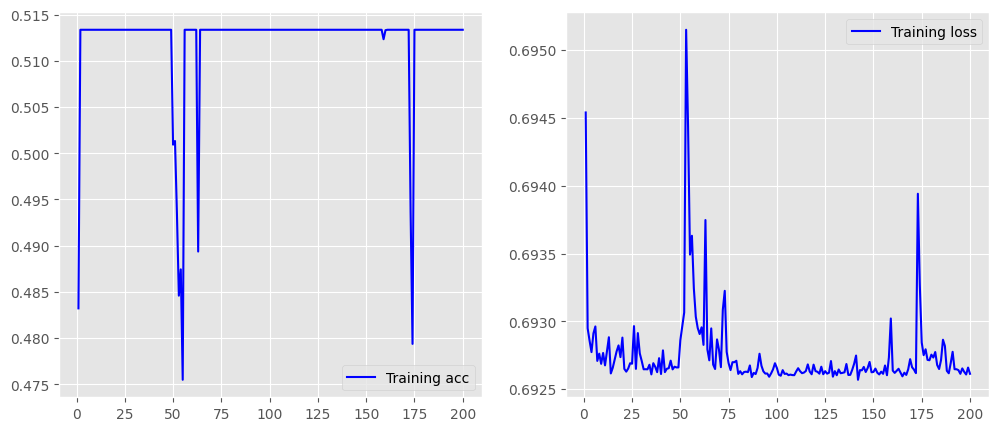

In [28]:
plot_history(history1)

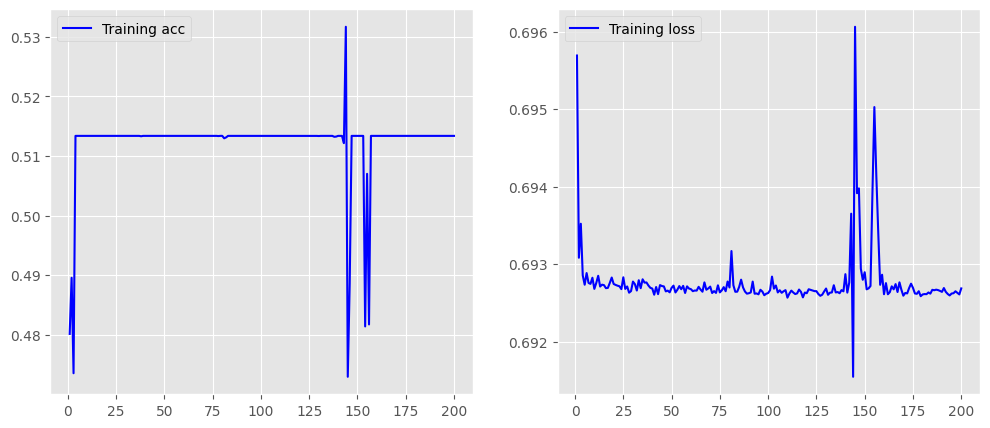

In [29]:
plot_history(history)

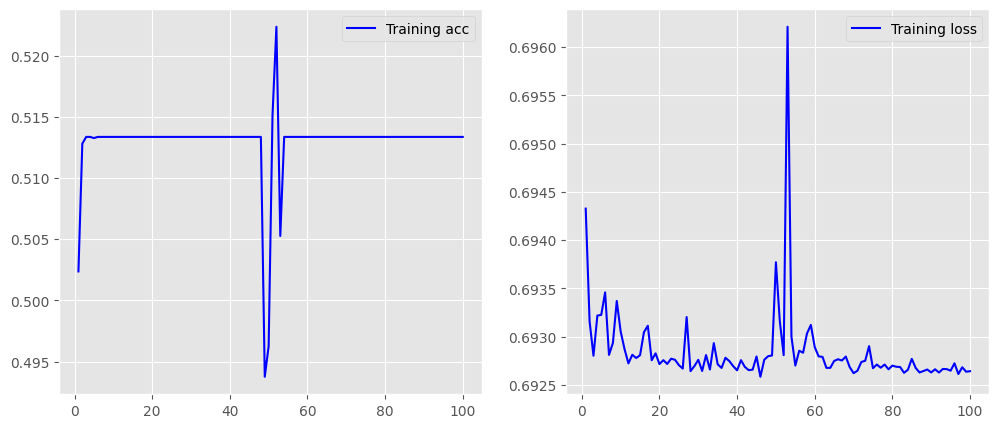

In [30]:
plot_history(history2)

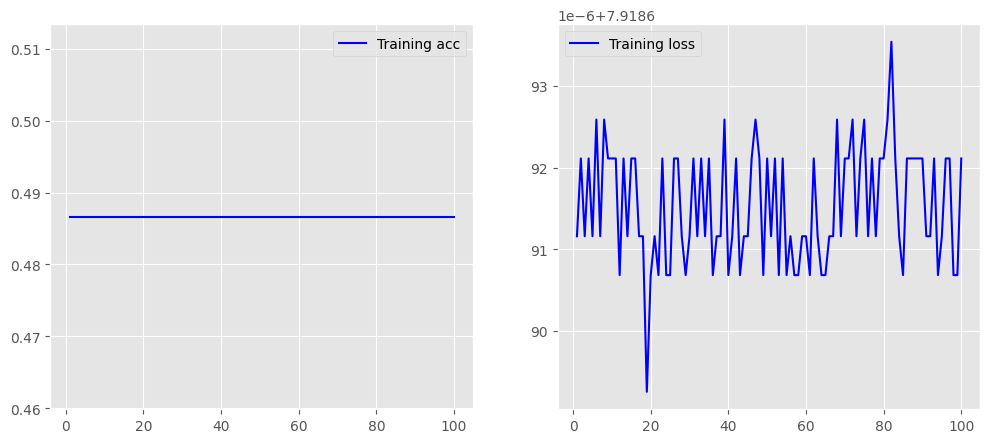

In [31]:
plot_history(history3)

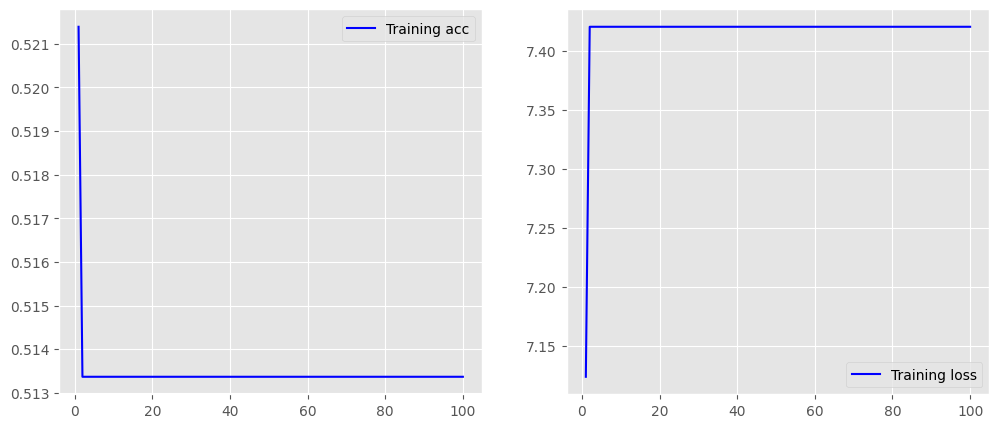

In [32]:
plot_history(history4)

In [ ]:
https://realpython.com/python-keras-text-classification/